In [1]:
import pandas as pd 
import numpy as np 
import spacy 
from plotnine import *

from stempel import StempelStemmer

In [93]:
class Stemmer:
    """
    Stemmer class allows us to load different lemmatisers
    SGJP - Morfeusz 
    Polimorf - Morfeus 
    Stempel - Stempel Polimorf
    """
    def __init__(self, stemmer_type):
        self.stem_dict = None 
        stemmer_type = stemmer_type.lower()
        self.stemmer_type = stemmer_type
        if stemmer_type == 'stempel':
            self.stem_dict = StempelStemmer.polimorf()
        else:
            filename = None 
            if stemmer_type == 'sgjp':
                filename = '../data/sgjp-20200202.tab'
            elif stemmer_type == 'polimorf':
                filename = '../data/polimorf-20190303.tab'
            else:
                raise ValueError("Invalid dict lemma type")
            self.stem_dict = pd.read_table(filename, sep='\t',
                                         index_col=False)
            self.stem_dict.drop_duplicates(subset='word', inplace=True)
            self.stem_dict.set_index("word", drop=True, inplace=True)
            self.stem_dict = self.stem_dict.to_dict(orient="index")
            
    def stem(self, word):
        if self.stemmer_type == 'stempel':
            return self.stem_dict.stem(word)
        else:
            if word in self.stem_dict:
                return self.stem_dict[word]['stem']
            else:
                return word

stemmer = Stemmer('sgjp')
nlp = spacy.load('pl_model')

In [4]:
import re 
rgx = re.compile('(\([0-9]+\))')
# dataset = pd.read_csv('../data/short_reviews_bert_10_1_10.csv')

import glob 
review_file = "../data/reviews_for_bert*.csv"

dataset = pd.DataFrame()
for rev_file in glob.glob(review_file):
    r = pd.read_csv(rev_file)
    dataset = pd.concat([dataset, r])

dataset = dataset[dataset.rating != -1]
dataset = dataset[~dataset.rating.between(4,7)]
print(dataset.count())
# balance positive/neg

neg_reviews = dataset[dataset.rating <= 4]
pos_reviews = dataset[dataset.rating >= 7].sample(len(neg_reviews))

balanced_reviews = pd.concat([pos_reviews, neg_reviews])
reviews, ratings = balanced_reviews.content.tolist(), balanced_reviews.rating.tolist()
print(balanced_reviews.count())
dataset = balanced_reviews

def extract_date(title):
    dt = rgx.search(title)
    if dt:
        return dt.group(1).replace('(', '').replace(')', '')
    else:
        return -1 

dataset['date'] = dataset['title'].apply(extract_date)

title      1358
rating     1358
content    1358
dtype: int64
title      1126
rating     1126
content    1126
dtype: int64


In [84]:
from collections import defaultdict, Counter
import pandas as pd 
import json 
import time 
import re

class DatasetPreprocessor:
    def __init__(self, sentiment_file=None,
                 stopwords_file=None):
        if stopwords_file:
            with open(stopwords_file, 'r') as f:
                self.stopwords = f.readlines()
        self.symbols_to_replace = ['.', ':', ';', '!', 
                                   '-', '\n', '\t', '\r']
        if sentiment_file:
            self.stdata = pd.read_csv(sentiment_file)
            self.sentiment_data = {}
            for w in self.stdata.word.unique():
                r = self.sentiment_read(w, stem=False)
                self.sentiment_data[w] = {
                    k: v for k, v in r.items()
                }
            del self.stdata
            
    def sentiment_read(self, candidate_word, stem=True):
        """
        {'word': 'terrorystyczny',
          'category': 'U',
          'mean Happiness': 1.4444443999999999,
          'mean Anger': 4.259258999999999,
          'mean Sadness': 4.222222299999999,
          'mean Fear': 5.148148,
          'mean Disgust': 4.740741000000001,
          'distance to H': 9.711846000000001,
          'distance to A': 7.990701700000001,
          'distance to S': 7.979814999999999,
          'distance to F': 7.240399000000001,
          'distance to D': 7.6377497000000005,
          'distance to N': 7.594883}
        
        """
        return_col_subset = ['mean Happiness', 'mean Anger',
                             'mean Sadness', 'mean Fear', 'mean Disgust']
#         empty_retval = {val: 0 for val in return_col_subset}
        empty_retval = None
        if stem:
            # try to lemmatise 
            candidate_word = stemmer.stem(candidate_word)
            
        retval = self.stdata[return_col_subset].loc[
            self.stdata['word'] == \
            candidate_word].to_dict(orient='records')
        if not retval:
            return empty_retval
        if len(retval) > 1:
            raise ValueError("There should be just a single word!")
        return retval[0] # there will be just one
            
    def preprocess_text_sample(self, text_sample):
        """
        Assumes the sample has been split into constituent parts
        """ 
        text_sample = self.preprocess_text_sample(text_sample=text_sample)
        new_text = []
        for word in text_sample:
            if word in stopwords:
                continue
            if word in self.lemmatiser:
                lemma = self.lemmatiser[word]
                new_text.append(lemma)
            else:
                # handle the non-existing word lemma
                # TODO
                pass 
        return ' '.join(new_text)
    
    def preprocess_text_sample_replace(self, text_sample):
        """
        Replaces the words in the list with blanks
        """
        for sym in self.symbols_to_replace:
            text_sample = text_sample.replace(sym, '')
        return text_sample
    
    def text_sentiment(self, text):
        stats = defaultdict(float)
        words = re.findall(r'\w+', text.lower())
        for word in words:
            c = 0
            tword = stemmer.stem(word)
            if tword in self.sentiment_data:
                retval = self.sentiment_data[tword]
                for lab in ['Happiness', 'Anger', 'Sadness', 'Disgust', 'Fear']:
                    stats[lab] += retval['mean ' + lab]
                c += 1
        stats['count'] += c
        stats['words'] += len(words)
        return stats
    
    def build_sentiment_statistics(self, text_samples):
        """
        Gather the statistics for the sentiment
        """
        stats = defaultdict(float)
        for text_sample in text_samples:
            words = re.findall(r'\w+', text_sample.lower())
            for word in words:
                c = 0
#                 retval = self.sentiment_read(candidate_word=word, stem=True)
                tword = stemmer.stem(word)
                if tword in self.sentiment_data:
                    retval = self.sentiment_data[tword]
                    for lab in ['Happiness', 'Anger', 'Sadness', 'Disgust', 'Fear']:
                        stats[lab] += retval['mean ' + lab]
                    c += 1
            stats['count'] += c
            stats['words'] += len(words)
        return stats

dp = DatasetPreprocessor(sentiment_file='../nlp-dicts/nawl-analysis.csv')

In [94]:
def process_dataset_sentiment(dataset):
    stats_per_rat = defaultdict(list)
    for rat in dataset.rating.unique():
        if rat == -1: # no rating was provided 
            continue
        sub_df = dataset.loc[dataset.rating == rat]
        stat = dp.build_sentiment_statistics(sub_df.content)
        if stat['count']:
            for lab in ['Happiness', 'Anger', 'Sadness', 'Disgust', 'Fear']:
                stats_per_rat['Emotion count'].append(stat[lab]/stat['count'])
                stats_per_rat['Emotion'].append(lab)
                stats_per_rat['Rating'].append(rat)
    
    stat_df = pd.DataFrame.from_dict(stats_per_rat)
    stat_df.sort_values(by='Rating', inplace=True)
    return stat_df

df = process_dataset_sentiment(dataset)
df['Score'] = pd.Categorical(df['Rating'], categories=df['Rating'].unique())
df.sort_values(by='Score', inplace=True)

In [112]:
dataset.count()

title      1126
rating     1126
content    1126
date       1126
dtype: int64

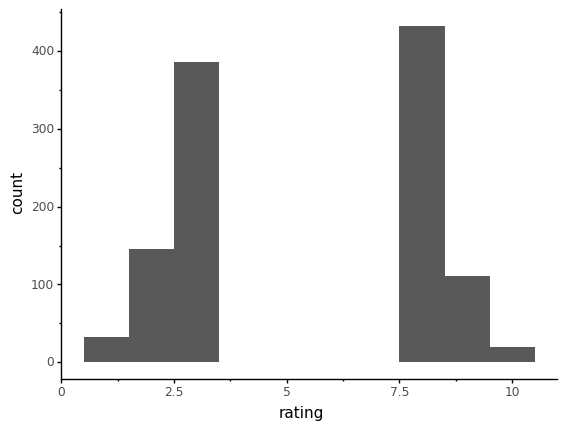

<ggplot: (1571105185)>

In [120]:
(ggplot(dataset, aes(x='rating'))
 + geom_histogram(bins=10)
 + theme_classic()
)

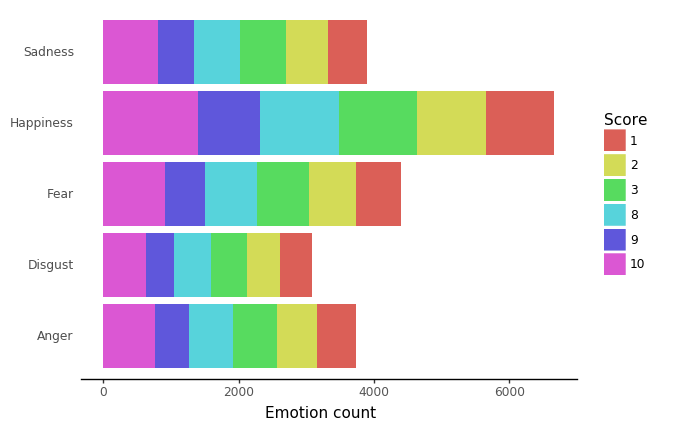

<ggplot: (1853207093)>

In [95]:
ccolor = '#555555'
(ggplot(df, aes(x='Emotion', y='Emotion count', fill='Score'))
 + geom_col() + coord_flip() 
 + theme(panel_background=element_rect(fill='white'),
         axis_title_y=element_blank(),
         axis_line_x=element_line(color='black'),
         axis_text_x=element_text(color=ccolor),
         axis_ticks_major_y=element_blank(),
         panel_grid=element_blank(),
         panel_border=element_blank())
)

In [96]:
new_stat = defaultdict(list)
for group, sub_df in df.groupby(by='Rating'):
    sm = sub_df['Emotion count'].sum()
    cumsum = 0
    for lab in sorted(['Happiness', 'Anger', 'Sadness', 'Disgust', 'Fear'], reverse=True):
        new_stat['Emotion'].append(lab)
        em_per = sub_df['Emotion count'][sub_df['Emotion'] == lab].iloc[0]*100/sm
        new_stat['Emotion %'].append(em_per)
        new_stat['%'].append(f"{int(em_per)}%")
        cumsum += em_per
        new_stat['Emotion pos'].append(cumsum-5)
        new_stat['Score'].append(group)
        
em_df = pd.DataFrame.from_dict(new_stat)

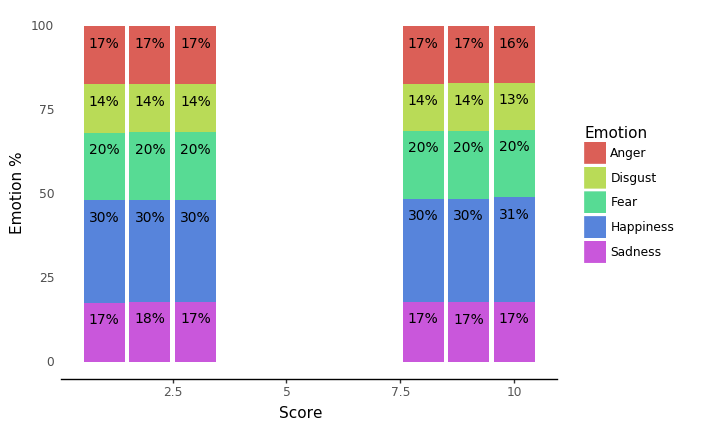

<ggplot: (1831210329)>

In [97]:
ccolor = '#555555'
(ggplot(em_df, aes(x='Score', y='Emotion %', fill='Emotion'))
 + geom_col()  
 + geom_text(em_df, aes(x='Score', y='Emotion pos', fill='Emotion', label='%'),
                       size=10)
 + theme(panel_background=element_rect(fill='white'),
         axis_line_x=element_line(color='black'),
         axis_text_x=element_text(color=ccolor),
         axis_ticks_major_y=element_blank(),
         panel_grid=element_blank(),
         panel_border=element_blank())
)

In [14]:
tiny_df = dataset

def map_review(text):
    entities = defaultdict(list)
    stats = dp.text_sentiment(text)
    doc = nlp(text)
    for ent in doc.ents:
        if ent.text.replace(" ", "").replace("\n", "").strip() != "":
            entities[ent.label_].append(ent.text.strip())
    return entities, stats

# contents = map(lambda x: map_review(x), tiny_df.)

reduced = defaultdict(lambda: defaultdict(list))
reviews_reduced = defaultdict(list)
ppl = Counter()

for text, rating, year, title in zip(tiny_df['content'].tolist(),
                                     tiny_df['rating'].tolist(),
                                     tiny_df['date'].tolist(),
                                     tiny_df['title'].tolist()):
    x, st = map_review(text)
    emotional_strength = 0
    for lab in ['Happiness', 'Anger', 'Sadness', 'Disgust', 'Fear']: 
        emotional_strength += st[lab]
    emotional_strength /= 4
    reviews_reduced['Happiness'].append(st['Happiness'])
    reviews_reduced['Sadness'].append(st['Sadness'])
    reviews_reduced['Disgust'].append(st['Disgust'])
    reviews_reduced['Anger'].append(st['Anger'])
    reviews_reduced['Emotion'].append(emotional_strength)
    reviews_reduced['Year'].append(year)
    reviews_reduced['Rating'].append(rating)
    reviews_reduced['Title'].append(title)
    
    for person in x['PERSON']:
        ppl[person] += 1
        reduced[person]['happiness'].append(st['Happiness'])
        reduced[person]['sadness'].append(st['Sadness'])
        reduced[person]['disgust'].append(st['Disgust'])
        reduced[person]['rating'].append(rating)
        reduced[person]['emotional_strength'].append(emotional_strength)

In [15]:
ppl.most_common(10)

df_data = defaultdict(list)
for person, count in ppl.most_common():
    df_data['Entity'].append(person)
    df_data['Count'].append(count)
    df_data['Emotion'].append(np.mean(reduced[person]['emotional_strength']))
    df_data['Score'].append(np.mean(reduced[person]['rating']))
    df_data['Disgust'].append(np.mean(reduced[person]['disgust']))
    df_data['Happiness'].append(np.mean(reduced[person]['happiness']))
    df_data['Sadness'].append(np.mean(reduced[person]['sadness']))

bubble_df = pd.DataFrame.from_dict(df_data)

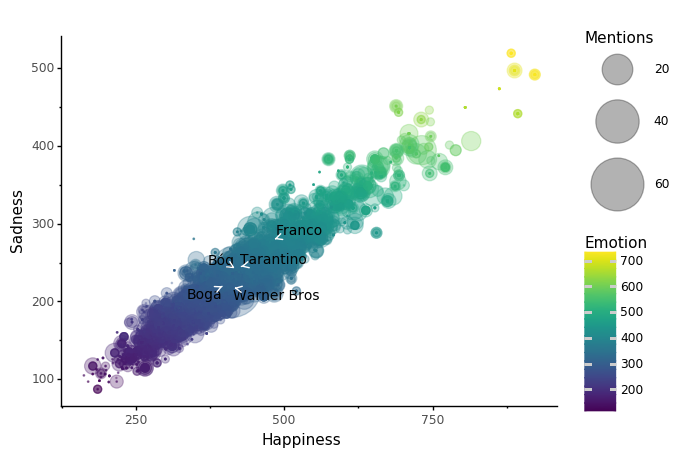

<ggplot: (358207969)>

In [16]:
selected_labels = [pp for pp, c, in ppl.most_common(5)]
(ggplot(bubble_df, 
        aes(x='Happiness', y='Sadness', size='Count',
           color='Emotion'))
 + geom_point(alpha=0.3)
 + theme_classic()
 + scale_size(range=(.1, 24), name="Mentions")
 + geom_text(bubble_df[bubble_df['Entity'].isin(selected_labels)],
            aes(label='Entity'), size=10, colour='black',
             adjust_text={
                 'arrowprops': {
                     'arrowstyle': '->',
                     'color': 'white'
                 }
             })
)

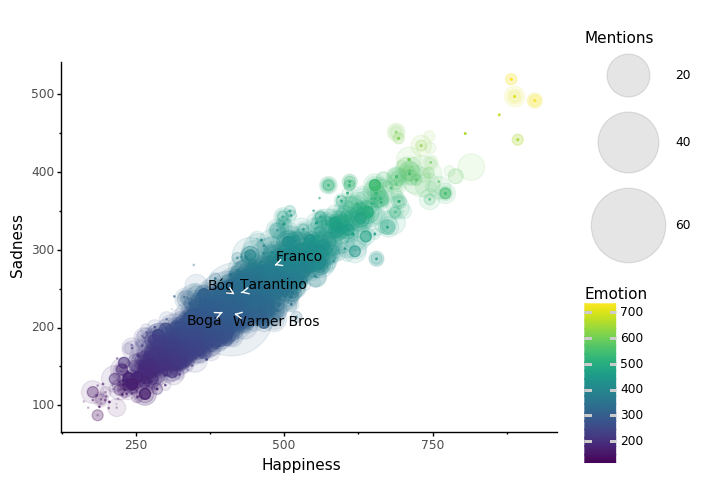

<ggplot: (355780289)>

In [30]:
selected_labels = [pp for pp, c, in ppl.most_common(5)]
(ggplot(bubble_df, 
        aes(x='Happiness', y='Sadness', size='Count',
           color='Emotion'))
 + geom_point(alpha=0.1)
 + theme_classic()
 + scale_size(range=(.1, 34), name="Mentions")
 + geom_text(bubble_df[bubble_df['Entity'].isin(selected_labels)],
            aes(x='Happiness', y='Sadness', label='Entity'), size=10, colour='black',
             adjust_text={
                 'arrowprops': {
                     'arrowstyle': '->',
                     'color': 'white'
                 }
             })
)

In [21]:
review_df = pd.DataFrame.from_dict(reviews_reduced)
review_df.head()

agg_year_data = defaultdict(list)
for year in review_df['Year'].unique():
    tdf = review_df[review_df['Year'] == year]
    for l in ['Happiness', 'Sadness', 'Anger',
              'Disgust']:
        agg_year_data['Emotion mean'].append(np.mean(tdf[l]))
        agg_year_data['Emotion'].append(l)
        agg_year_data['Year'].append(year)
agg_df = pd.DataFrame.from_dict(agg_year_data)

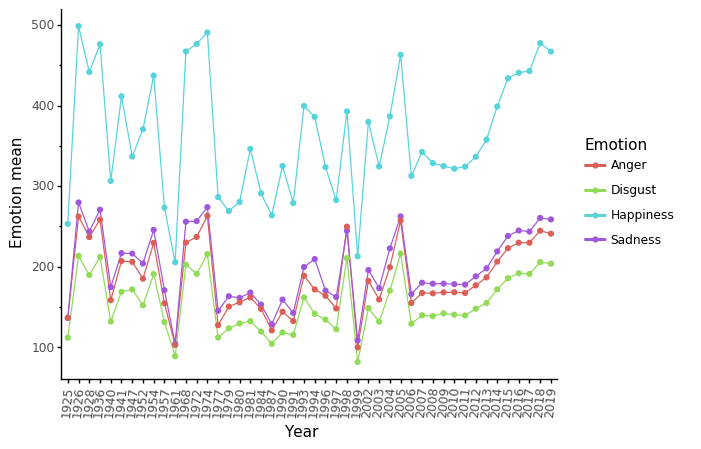

<ggplot: (425863349)>

In [29]:
(ggplot(data=agg_df, mapping=aes(x='Year', 
                         y='Emotion mean', group='Emotion', color='Emotion'))
 + geom_line()
 + geom_point()
 + theme_classic()
 + theme(axis_text_x=element_text(rotation=85, hjust=2))
)

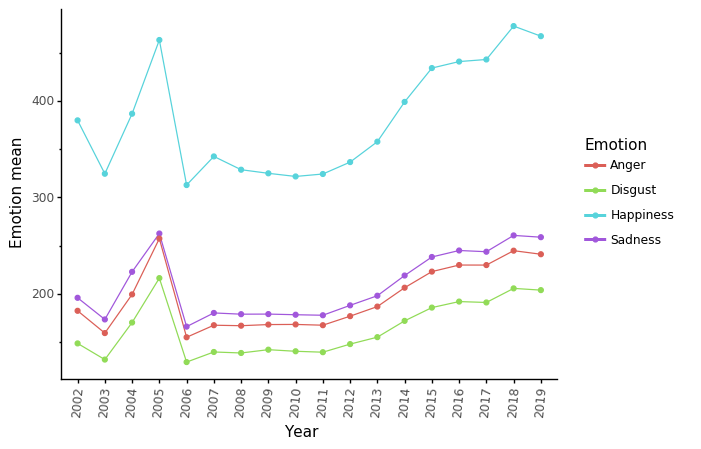

<ggplot: (422030657)>

In [26]:
(ggplot(data=agg_df[agg_df['Year'].isin([str(i) for i in range(2000, 2020)])], mapping=aes(x='Year', 
                         y='Emotion mean', group='Emotion', color='Emotion'))
 + geom_line()
 + geom_point()
 + theme_classic()
 + theme(axis_text_x=element_text(rotation=85, hjust=2))
)

[('Warner Bros', 78),
 ('Boga', 48),
 ('Bóg', 43),
 ('Franco', 34),
 ('Tarantino', 31),
 ('Joe', 30),
 ('Jezusa', 27),
 ('George', 27),
 ('Anna', 25),
 ('Films', 25)]